In [60]:
import math

import igraph as ig
import matplotlib.pyplot as plt
from math import factorial, exp
import numpy as np
from utils import random_walk, walk_stats, catalan_number, full_histogram, poisson_expectation
import pandas as pd
from tqdm.notebook import tqdm
import markov as mkv
from statistics import mean
import scipy.special as sc

In [61]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'medium'}
pylab.rcParams.update(params)

# Retroceding random walk

In [62]:
dfo = pd.concat([pd.read_hdf(f'./data/walks_0-4_s200000.h5', 'table'),pd.read_hdf(f'./data/walks_0-1_s200000.h5', 'table')])
dfo['c'] = dfo['c'].round(3)

In [63]:
def analytic_er1(c, t):
    if t % 2 == 1:
        return 0
    else:
        return (catalan_number(int(t / 2 - 1)) * (c + 1) * c * ((c + 1) ** (t / 2 - 1))) / (
            ((c + 1) ** (t)))


def inverse(c, t):
    if t % 2 == 1:
        return 0
    else:
        k = int(t / 2)
        return catalan_number(k - 1) * (c / (c + 1)) ** (k - 1) * (1 / (c + 1)) ** k


def inverseexp(c, t):
    return 1/(exp(t))

def roundtrip_expectation(c, t):
    if t % 2 == 1:
        return 0
    else:
        k = int(t / 2)
        return catalan_number(k - 1) * poisson_expectation(lambda x: 1 / (x + 1), c) * \
            poisson_expectation(lambda x: x / (x + 1) ** 2, c) ** (k - 1)


def analytic_er2(c, t):
    if t % 2 == 1:
        return 0
    if t == 2:
        return poisson_expectation(lambda x: 1 / (x + 1), c)
    else:
        return  0*(catalan_number(int(t / 2 - 1))-1) * poisson_expectation(lambda x: 1 / (x + 2), c) * poisson_expectation(lambda x: x / (x + 2) ** 2, c) ** (
                     t / 2 - 1) + \
    poisson_expectation(lambda x: x / (x + 1) ** (t / 2), c) * poisson_expectation(
                lambda x: 1 / (x + 1) ** (t / 2 - 1), c)


def mean_field_with_expectation(c, t):
    if t % 2 == 1:
        return 0
    if t==2:
        return analytic_er2(c, t)
    else:
        k = int(t / 2)
        return catalan_number(k-1) * poisson_expectation(lambda x: x / (x + 1) ** 2, c) \
           * poisson_expectation(lambda x: 1 / (x + 1), c) * (c / (c + 1)) ** (k - 2) * (1 / (c + 1)) ** (k-2)
      #  return catalan_number(k - 1) * (1-exp(-c))/(c) * ((c) / (c + 1)) ** (k - 1) * (1 / (c + 1)) ** (k-1)


def mean_field(c, t):
    if t % 2 == 1:
        return 0
    else:
        k = int(t / 2)
        return catalan_number(k - 1) * (c / (c + 1)) ** (k - 1) * (1/(c+1))**k


def avg(c, t):
    return (mean_field(c, t) + roundtrip_expectation(c, t)) / 2


def simulation_data(dfo, c):
    df = dfo[(dfo['c'] == c) & (dfo['walk_length'] > 0)]
    s = df.shape[0]
    df = df.groupby(['walk_length', 'is_retroceding']).count().reset_index()
    df['p'] = df['c'] / s
    df = df[df['is_retroceding'] == True]
    df = df[df['walk_length'].isin(times)]
    return df['walk_length'], df['p']

In [56]:
c = 0.5
times = range(2, 10, 2)

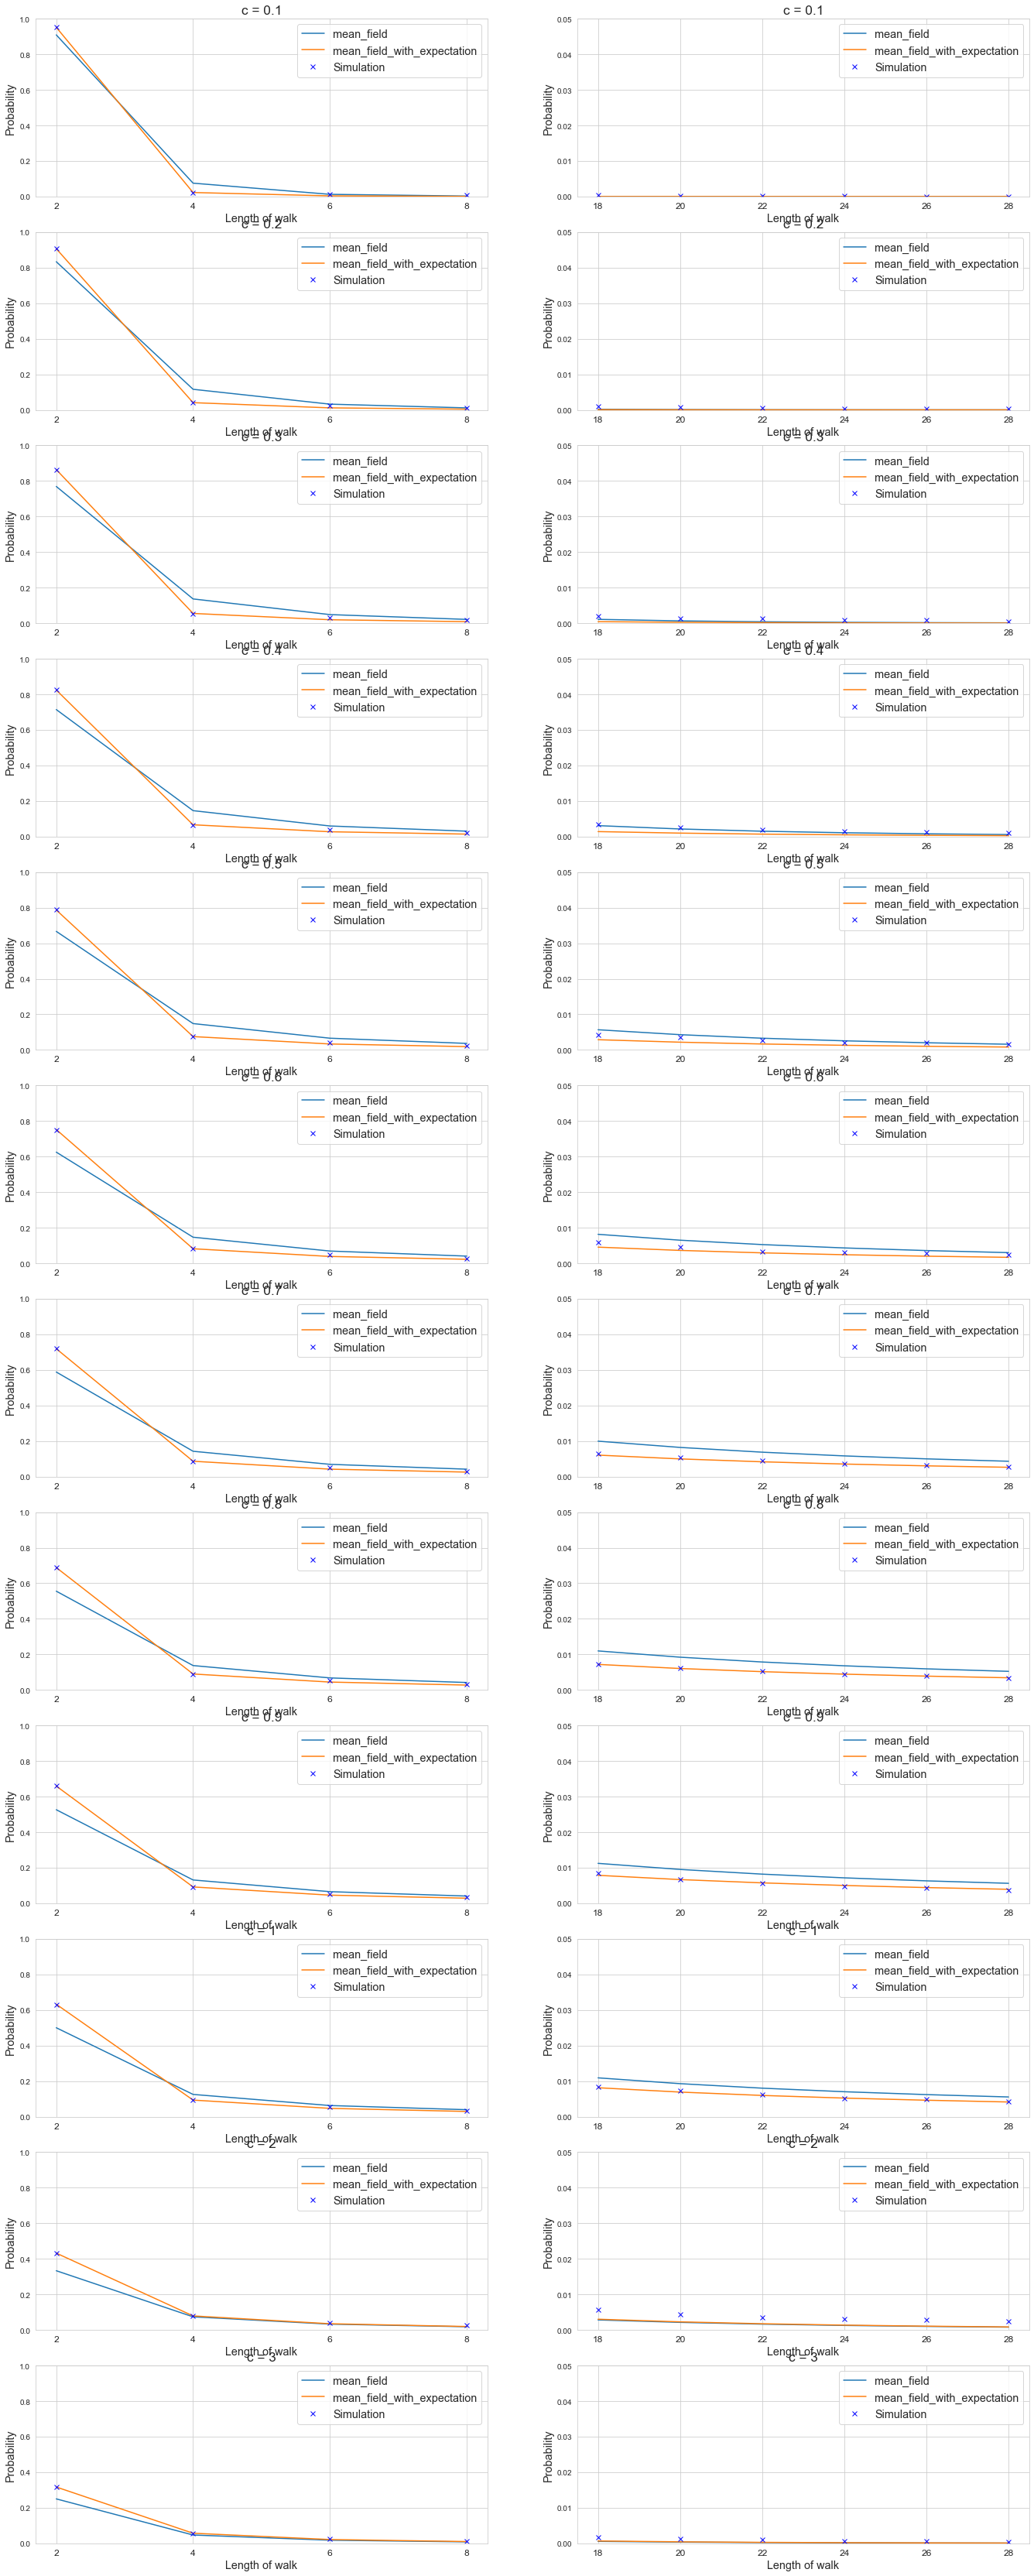

In [59]:
functions_to_plot = [mean_field]#, analytic_er2]  #, roundtrip_expectation, avg]

cs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 2, 3]

plt.figure(figsize=(23, 60))
# plt.suptitle("First Return Time Distribution")
plt.tight_layout()

for i, c in enumerate(cs):

    plt.subplot(len(cs), 2, 2*i+1)

    times = range(2, 10, 2)
    for f in functions_to_plot:
        y = [f(c, t) for t in times]
        plt.plot(times, y, label=f.__name__)

    sim_times, sim_probs = simulation_data(dfo, c)
    plt.plot(sim_times, sim_probs, "xb", label="Simulation")

    plt.xticks(times)
    plt.xlabel("Length of walk")
    plt.ylabel("Probability")
    plt.ylim([0, 1])
    plt.title(f"c = {c}")
    plt.legend()


    plt.subplot(len(cs), 2, 2*i+2)

    times = range(18, 30, 2)
    for f in functions_to_plot:
        y = [f(c, t) for t in times]
        plt.plot(times, y, label=f.__name__)

    sim_times, sim_probs = simulation_data(dfo, c)
    plt.plot(sim_times, sim_probs, "xb", label="Simulation")

    plt.xticks(times)
    plt.xlabel("Length of walk")
    plt.ylabel("Probability")
    plt.ylim([0, 0.05])
    plt.title(f"c = {c}")
    plt.legend()



In [254]:
dfo[dfo['c']==0.3]

,walk_length,distinct_sites,is_retroceding,start_node_degree,component_size,c
0,2,2,True,1,2,0.3
1,2,2,True,1,2,0.3
2,2,2,True,1,2,0.3
3,2,2,True,1,2,0.3
4,2,2,True,1,5,0.3
...,...,...,...,...,...,...
199995,2,2,True,1,2,0.3
199996,2,2,True,1,2,0.3
199997,2,2,True,1,2,0.3
199998,2,2,True,2,4,0.3


In [249]:
dfo[dfo['c']==0.3]

,walk_length,distinct_sites,is_retroceding,start_node_degree,component_size,c
